# Data Analysis

In [2]:
import gzip
import struct
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 6)

## 1. Load and Parse Binary Data

In [3]:
# Configuration
PRICE_SCALE = 100_000
SIZE_SCALE = 100
TIME_UNIT = 1_000_000

# Publisher ID mapping (Databento standard)
PUBLISHER_NAMES = {
    1: 'NASDAQ',
    2: 'NYSE',
    3: 'NYSE Arca',
    4: 'Cboe BZX',
    5: 'IEX',
    6: 'NASDAQ BX',
    43: 'NASDAQ PSX'
}

def parse_binary():
    """Parse binary file and return DataFrame."""
    data_file = Path('../sessions/GLMD-20251117.bin.gz')
    
    with gzip.open(data_file, 'rb') as f:
        buffer = f.read()
    
    # Parse header
    offset = 0
    magic = buffer[offset:offset+4].decode('utf-8')
    offset += 4
    version = struct.unpack('<H', buffer[offset:offset+2])[0]
    offset += 2
    resample_interval_ms = struct.unpack('<H', buffer[offset:offset+2])[0]
    offset += 2
    num_samples = struct.unpack('<I', buffer[offset:offset+4])[0]
    offset += 4
    initial_timestamp_us = struct.unpack('<Q', buffer[offset:offset+8])[0]
    offset += 8
    
    # Read publisher map
    publisher_map_length = struct.unpack('<H', buffer[offset:offset+2])[0]
    offset += 2
    publisher_map_str = buffer[offset:offset+publisher_map_length].decode('utf-8')
    offset += publisher_map_length
    
    publisher_map = {}
    for pair in publisher_map_str.split(','):
        idx, pub_id = pair.split(':')
        publisher_map[int(idx)] = int(pub_id)
    
    print(f"Magic: {magic}")
    print(f"Version: {version}")
    print(f"Resample interval: {resample_interval_ms}ms")
    print(f"Total samples: {num_samples:,}")
    print(f"Publisher map: {publisher_map}")
    print(f"Start time: {datetime.fromtimestamp(initial_timestamp_us/1000000)}")
    print()
    
    # Parse samples
    data = []
    cumulative_timestamp_ms = initial_timestamp_us / 1000
    
    for i in range(num_samples):
        # Time delta
        time_delta_ms = struct.unpack('<i', buffer[offset:offset+4])[0]
        offset += 4
        cumulative_timestamp_ms += time_delta_ms
        
        # NBBO data
        nbbo_bid = struct.unpack('<i', buffer[offset:offset+4])[0] / PRICE_SCALE
        offset += 4
        nbbo_ask = struct.unpack('<i', buffer[offset:offset+4])[0] / PRICE_SCALE
        offset += 4
        nbbo_bid_size = struct.unpack('<i', buffer[offset:offset+4])[0] / SIZE_SCALE
        offset += 4
        nbbo_ask_size = struct.unpack('<i', buffer[offset:offset+4])[0] / SIZE_SCALE
        offset += 4
        best_bid_pub = struct.unpack('<B', buffer[offset:offset+1])[0]
        offset += 1
        best_ask_pub = struct.unpack('<B', buffer[offset:offset+1])[0]
        offset += 1
        
        # Exchange snapshots
        num_exchanges = struct.unpack('<B', buffer[offset:offset+1])[0]
        offset += 1
        
        exchanges = []
        for j in range(num_exchanges):
            pub_idx = struct.unpack('<B', buffer[offset:offset+1])[0]
            offset += 1
            bid = struct.unpack('<i', buffer[offset:offset+4])[0] / PRICE_SCALE
            offset += 4
            ask = struct.unpack('<i', buffer[offset:offset+4])[0] / PRICE_SCALE
            offset += 4
            bid_size = struct.unpack('<I', buffer[offset:offset+4])[0] / SIZE_SCALE
            offset += 4
            ask_size = struct.unpack('<I', buffer[offset:offset+4])[0] / SIZE_SCALE
            offset += 4
            
            pub_id = publisher_map.get(pub_idx, pub_idx)
            exchanges.append({
                'pub_id': pub_id,
                'pub_name': PUBLISHER_NAMES.get(pub_id, f'Unknown-{pub_id}'),
                'bid': bid,
                'ask': ask,
                'bid_size': bid_size,
                'ask_size': ask_size,
                'spread': ask - bid,
                'mid': (bid + ask) / 2
            })
        
        timestamp = datetime.fromtimestamp(cumulative_timestamp_ms / 1000)
        mid_price = (nbbo_bid + nbbo_ask) / 2
        
        data.append({
            'timestamp': timestamp,
            'nbbo_bid': nbbo_bid,
            'nbbo_ask': nbbo_ask,
            'nbbo_mid': mid_price,
            'nbbo_spread': nbbo_ask - nbbo_bid,
            'nbbo_bid_size': nbbo_bid_size,
            'nbbo_ask_size': nbbo_ask_size,
            'best_bid_pub': publisher_map.get(best_bid_pub, best_bid_pub),
            'best_ask_pub': publisher_map.get(best_ask_pub, best_ask_pub),
            'num_exchanges': num_exchanges,
            'exchanges': exchanges
        })
    
    df = pd.DataFrame(data)
    print(f"Loaded {len(df):,} samples")
    return df, publisher_map

df, publisher_map = parse_binary()
df

Magic: TICK
Version: 3
Resample interval: 100ms
Total samples: 35,961
Publisher map: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 43}
Start time: 2025-11-17 14:30:03.800000

Loaded 35,961 samples


,timestamp,nbbo_bid,nbbo_ask,nbbo_mid,nbbo_spread,nbbo_bid_size,nbbo_ask_size,best_bid_pub,best_ask_pub,num_exchanges,exchanges
0,2025-11-17 14:30:03.800,0.941,1.00,0.9705,0.059,300.0,4794.0,1,1,1,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 0...."
1,2025-11-17 14:30:03.900,0.941,1.00,0.9705,0.059,300.0,4794.0,1,1,1,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 0...."
2,2025-11-17 14:30:04.000,0.941,1.00,0.9705,0.059,300.0,4794.0,1,1,1,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 0...."
3,2025-11-17 14:30:04.100,0.941,1.00,0.9705,0.059,300.0,4794.0,1,1,1,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 0...."
4,2025-11-17 14:30:04.200,0.941,1.00,0.9705,0.059,300.0,4794.0,1,1,1,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 0...."
...,...,...,...,...,...,...,...,...,...,...,...
35956,2025-11-17 15:29:59.400,1.510,1.26,1.3850,-0.250,100.0,7145.0,43,1,7,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
35957,2025-11-17 15:29:59.500,1.510,1.26,1.3850,-0.250,100.0,7145.0,43,1,7,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
35958,2025-11-17 15:29:59.600,1.510,1.25,1.3800,-0.260,100.0,3683.0,43,1,7,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
35959,2025-11-17 15:29:59.700,1.510,1.25,1.3800,-0.260,100.0,3583.0,43,1,7,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."


In [4]:
df[df['nbbo_spread']<0]

,timestamp,nbbo_bid,nbbo_ask,nbbo_mid,nbbo_spread,nbbo_bid_size,nbbo_ask_size,best_bid_pub,best_ask_pub,num_exchanges,exchanges
241,2025-11-17 14:30:27.900,1.23,1.19,1.210,-0.04,100.0,0.0,1,6,4,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
242,2025-11-17 14:30:28.000,1.23,1.19,1.210,-0.04,100.0,0.0,1,6,4,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
243,2025-11-17 14:30:28.100,1.23,1.19,1.210,-0.04,100.0,0.0,1,6,4,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
244,2025-11-17 14:30:28.200,1.23,1.19,1.210,-0.04,100.0,0.0,1,6,4,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
245,2025-11-17 14:30:28.300,1.23,1.19,1.210,-0.04,100.0,0.0,1,6,4,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
...,...,...,...,...,...,...,...,...,...,...,...
35956,2025-11-17 15:29:59.400,1.51,1.26,1.385,-0.25,100.0,7145.0,43,1,7,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
35957,2025-11-17 15:29:59.500,1.51,1.26,1.385,-0.25,100.0,7145.0,43,1,7,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
35958,2025-11-17 15:29:59.600,1.51,1.25,1.380,-0.26,100.0,3683.0,43,1,7,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."
35959,2025-11-17 15:29:59.700,1.51,1.25,1.380,-0.26,100.0,3583.0,43,1,7,"[{'pub_id': 1, 'pub_name': 'NASDAQ', 'bid': 1...."


## 2. Basic Statistics

In [5]:
print("=" * 80)
print("NBBO Statistics")
print("=" * 80)
print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min())}")
print()
print("Price Range:")
print(f"  Min bid: ${df['nbbo_bid'].min():.5f}")
print(f"  Max ask: ${df['nbbo_ask'].max():.5f}")
print(f"  Min mid: ${df['nbbo_mid'].min():.5f}")
print(f"  Max mid: ${df['nbbo_mid'].max():.5f}")
print()
print("Spread Statistics:")
print(f"  Mean spread: ${df['nbbo_spread'].mean():.5f}")
print(f"  Median spread: ${df['nbbo_spread'].median():.5f}")
print(f"  Min spread: ${df['nbbo_spread'].min():.5f}")
print(f"  Max spread: ${df['nbbo_spread'].max():.5f}")
print(f"  Std spread: ${df['nbbo_spread'].std():.5f}")
print()
print("Exchange Participation:")
print(f"  Mean exchanges per sample: {df['num_exchanges'].mean():.2f}")
print(f"  Max exchanges: {df['num_exchanges'].max()}")

NBBO Statistics
Time range: 2025-11-17 14:30:03.800000 to 2025-11-17 15:29:59.800000
Duration: 0 days 00:59:56

Price Range:
  Min bid: $0.94100
  Max ask: $1.58000
  Min mid: $0.97050
  Max mid: $1.61000

Spread Statistics:
  Mean spread: $-0.10792
  Median spread: $-0.08000
  Min spread: $-0.30000
  Max spread: $0.19000
  Std spread: $0.09187

Exchange Participation:
  Mean exchanges per sample: 6.41
  Max exchanges: 7


## 3. Identify Wide Spreads and Anomalies

In [6]:
# Find samples with abnormally wide spreads
spread_threshold = df['nbbo_spread'].quantile(0.99)  # 99th percentile
wide_spreads = df[df['nbbo_spread'] > spread_threshold].copy()

print(f"Spread threshold (99th percentile): ${spread_threshold:.5f}")
print(f"Samples with wide spreads: {len(wide_spreads):,} ({100*len(wide_spreads)/len(df):.2f}%)")
print()
print("Top 10 widest spreads:")
wide_spreads.nlargest(10, 'nbbo_spread')[['timestamp', 'nbbo_bid', 'nbbo_ask', 'nbbo_spread', 'best_bid_pub', 'best_ask_pub']]

Spread threshold (99th percentile): $0.02000
Samples with wide spreads: 309 (0.86%)

Top 10 widest spreads:


,timestamp,nbbo_bid,nbbo_ask,nbbo_spread,best_bid_pub,best_ask_pub
72,2025-11-17 14:30:11.000,1.0,1.19,0.19,4,6
73,2025-11-17 14:30:11.100,1.0,1.19,0.19,4,6
74,2025-11-17 14:30:11.200,1.0,1.19,0.19,4,6
75,2025-11-17 14:30:11.300,1.0,1.19,0.19,4,6
76,2025-11-17 14:30:11.400,1.0,1.19,0.19,4,6
77,2025-11-17 14:30:11.500,1.0,1.19,0.19,4,6
78,2025-11-17 14:30:11.600,1.0,1.19,0.19,4,6
79,2025-11-17 14:30:11.700,1.0,1.19,0.19,4,6
80,2025-11-17 14:30:11.800,1.0,1.19,0.19,4,6
81,2025-11-17 14:30:11.900,1.0,1.19,0.19,4,6


In [7]:
print("Top 10 smallest spreads:")
wide_spreads.nsmallest(10, 'nbbo_spread')[['timestamp', 'nbbo_bid', 'nbbo_ask', 'nbbo_spread', 'best_bid_pub', 'best_ask_pub']]

Top 10 smallest spreads:


,timestamp,nbbo_bid,nbbo_ask,nbbo_spread,best_bid_pub,best_ask_pub
402,2025-11-17 14:30:44.000,1.15999,1.18,0.02001,2,1
413,2025-11-17 14:30:45.100,1.15999,1.18,0.02001,2,3
414,2025-11-17 14:30:45.200,1.15999,1.18,0.02001,2,3
1008,2025-11-17 14:31:44.600,1.19000,1.22,0.03000,2,3
1009,2025-11-17 14:31:44.700,1.19000,1.22,0.03000,2,3
1010,2025-11-17 14:31:44.800,1.19000,1.22,0.03000,2,3
1011,2025-11-17 14:31:44.900,1.19000,1.22,0.03000,2,3
1012,2025-11-17 14:31:45.000,1.19000,1.22,0.03000,2,3
1013,2025-11-17 14:31:45.100,1.19000,1.22,0.03000,2,3
1014,2025-11-17 14:31:45.200,1.20000,1.23,0.03000,3,3


In [8]:
# Find price jumps (potential wicks)
df['mid_change'] = df['nbbo_mid'].diff().abs()
jump_threshold = df['mid_change'].quantile(0.995)  # 99.5th percentile
price_jumps = df[df['mid_change'] > jump_threshold].copy()

print(f"Price jump threshold (99.5th percentile): ${jump_threshold:.5f}")
print(f"Samples with large price jumps: {len(price_jumps):,}")
print()
print("Top 10 largest price jumps:")
print(price_jumps.nlargest(10, 'mid_change')[['timestamp', 'nbbo_mid', 'mid_change', 'nbbo_spread', 'best_bid_pub', 'best_ask_pub']])

Price jump threshold (99.5th percentile): $0.01000
Samples with large price jumps: 115

Top 10 largest price jumps:
                    timestamp  nbbo_mid  mid_change  nbbo_spread  \
11973 2025-11-17 14:50:01.100  1.575000    0.135000      0.01000   
19    2025-11-17 14:30:05.700  1.078745    0.097745      0.16249   
390   2025-11-17 14:30:42.800  1.174995    0.085005      0.03001   
31    2025-11-17 14:30:06.900  1.140000    0.074005      0.10000   
173   2025-11-17 14:30:21.100  1.120000    0.070000      0.14000   
396   2025-11-17 14:30:43.400  1.134995    0.065005     -0.04999   
4078  2025-11-17 14:36:51.600  1.175000    0.065000      0.01000   
147   2025-11-17 14:30:18.500  1.155000    0.060000      0.07000   
354   2025-11-17 14:30:39.200  1.295000    0.055000     -0.21000   
72    2025-11-17 14:30:11.000  1.095000    0.045000      0.19000   

       best_bid_pub  best_ask_pub  
11973             1             1  
19                1             3  
390               1        

## 4. Exchange-Level Analysis

In [9]:
# Extract exchange-level data
exchange_data = []
for idx, row in df.iterrows():
    for ex in row['exchanges']:
        exchange_data.append({
            'timestamp': row['timestamp'],
            'pub_id': ex['pub_id'],
            'pub_name': ex['pub_name'],
            'bid': ex['bid'],
            'ask': ex['ask'],
            'spread': ex['spread'],
            'mid': ex['mid']
        })

ex_df = pd.DataFrame(exchange_data)

print("Exchange Spread Statistics:")
print("=" * 80)
spread_by_exchange = ex_df.groupby('pub_name')['spread'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
spread_by_exchange = spread_by_exchange.sort_values('mean', ascending=False)
print(spread_by_exchange)

Exchange Spread Statistics:
            count      mean  median       std      min     max
pub_name                                                      
NASDAQ BX   35942  0.055300    0.03  0.073843  0.01000  0.4200
NASDAQ PSX  34718  0.027718    0.03  0.011033 -0.01000  0.0600
Cboe BZX    35942  0.024786    0.01  0.057919  0.00999  0.5000
NYSE        35571  0.020346    0.01  0.027065  0.00000  0.2500
NASDAQ      35961  0.015170    0.01  0.027762  0.00999  0.3937
IEX         16552  0.012499    0.01  0.004684  0.01000  0.0400
NYSE Arca   35949  0.012412    0.01  0.017959  0.00999  0.2880


In [10]:
# Find exchanges with abnormally wide spreads
wide_spread_threshold = 1.0  # $1 spread
wide_exchange_quotes = ex_df[ex_df['spread'] > wide_spread_threshold].copy()

print(f"Exchange quotes with spread > ${wide_spread_threshold}:")
print(wide_exchange_quotes.groupby('pub_name').size().sort_values(ascending=False))
print()
print("Sample of wide spreads:")
print(wide_exchange_quotes.nlargest(20, 'spread')[['timestamp', 'pub_name', 'bid', 'ask', 'spread']])

Exchange quotes with spread > $1.0:
Series([], dtype: int64)

Sample of wide spreads:
Empty DataFrame
Columns: [timestamp, pub_name, bid, ask, spread]
Index: []


## 5. Visualizations

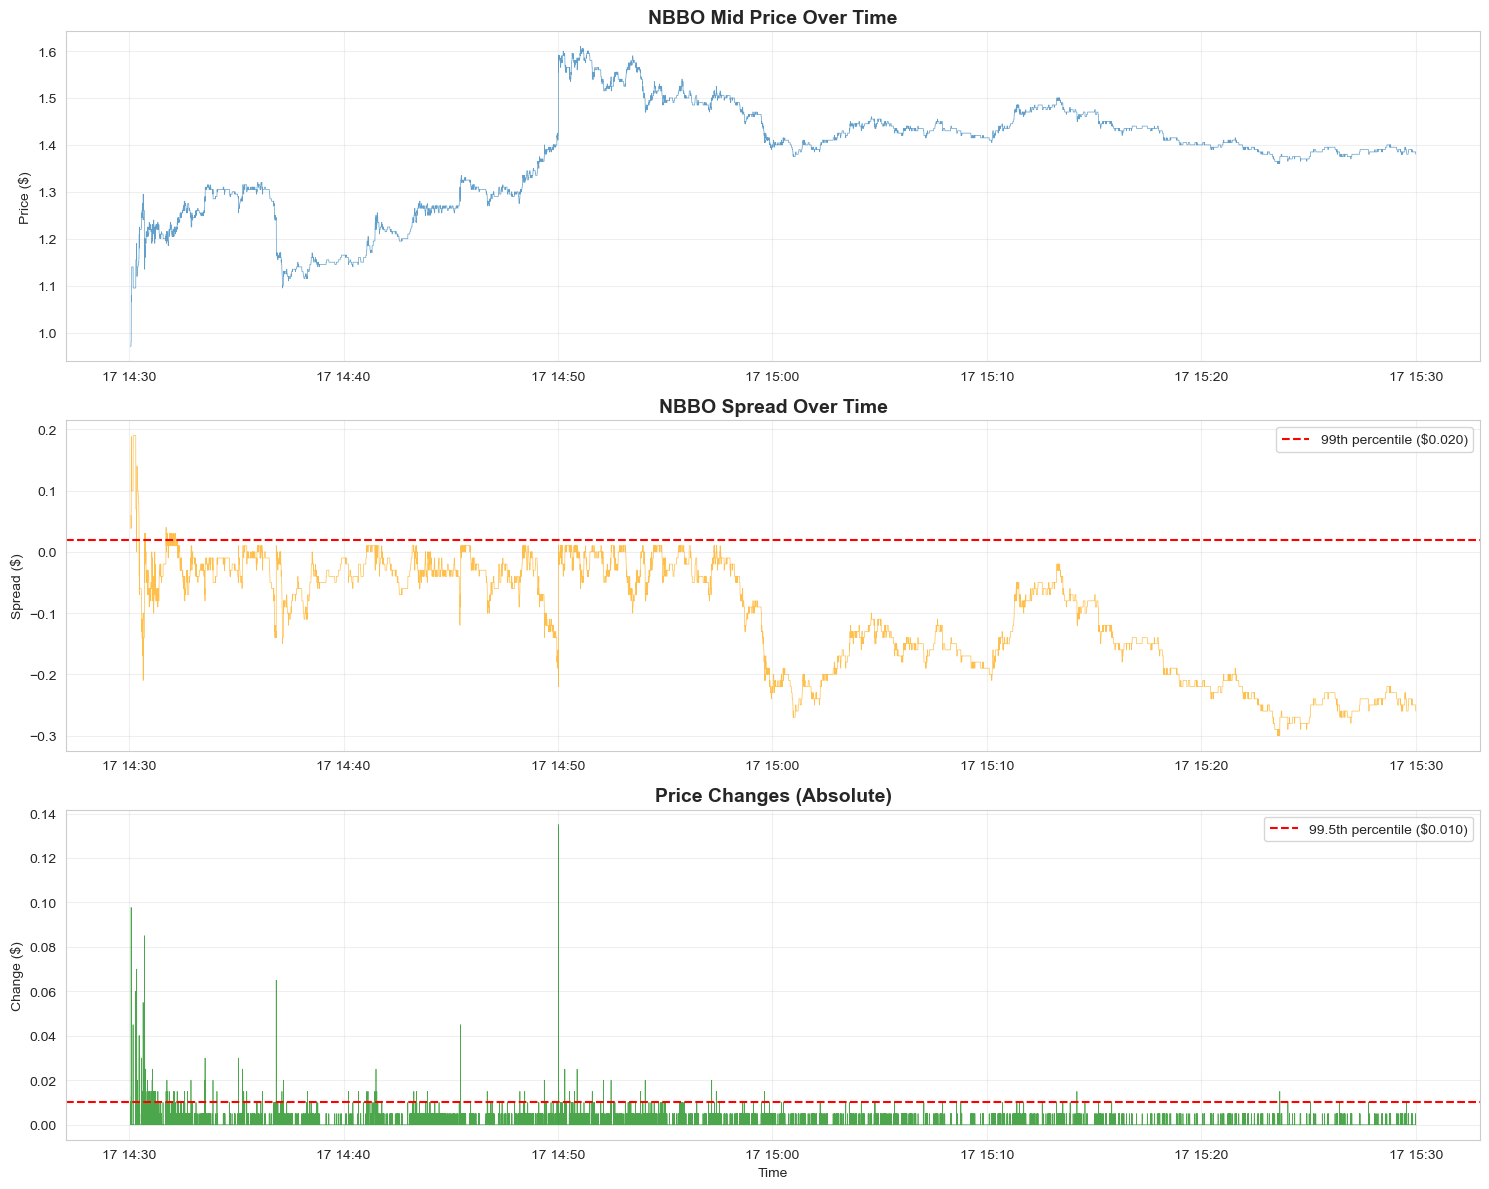

In [11]:
# Plot NBBO mid price over time
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Mid price
axes[0].plot(df['timestamp'], df['nbbo_mid'], linewidth=0.5, alpha=0.7)
axes[0].set_title('NBBO Mid Price Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# Spread over time
axes[1].plot(df['timestamp'], df['nbbo_spread'], linewidth=0.5, alpha=0.7, color='orange')
axes[1].axhline(y=spread_threshold, color='red', linestyle='--', label=f'99th percentile (${spread_threshold:.3f})')
axes[1].set_title('NBBO Spread Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Spread ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Price changes (jumps)
axes[2].plot(df['timestamp'], df['mid_change'], linewidth=0.5, alpha=0.7, color='green')
axes[2].axhline(y=jump_threshold, color='red', linestyle='--', label=f'99.5th percentile (${jump_threshold:.3f})')
axes[2].set_title('Price Changes (Absolute)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Change ($)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

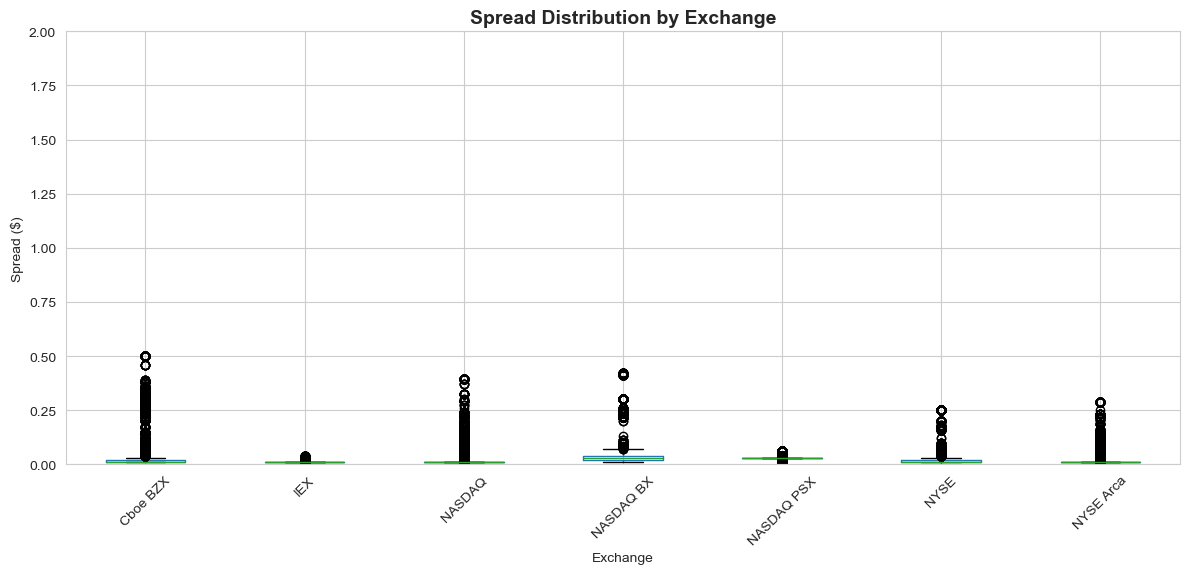

In [12]:
# Spread distribution by exchange
fig, ax = plt.subplots(figsize=(12, 6))
ex_df.boxplot(column='spread', by='pub_name', ax=ax)
ax.set_title('Spread Distribution by Exchange', fontsize=14, fontweight='bold')
ax.set_xlabel('Exchange')
ax.set_ylabel('Spread ($)')
ax.set_ylim(0, 2)  # Limit to $2 for better visibility
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

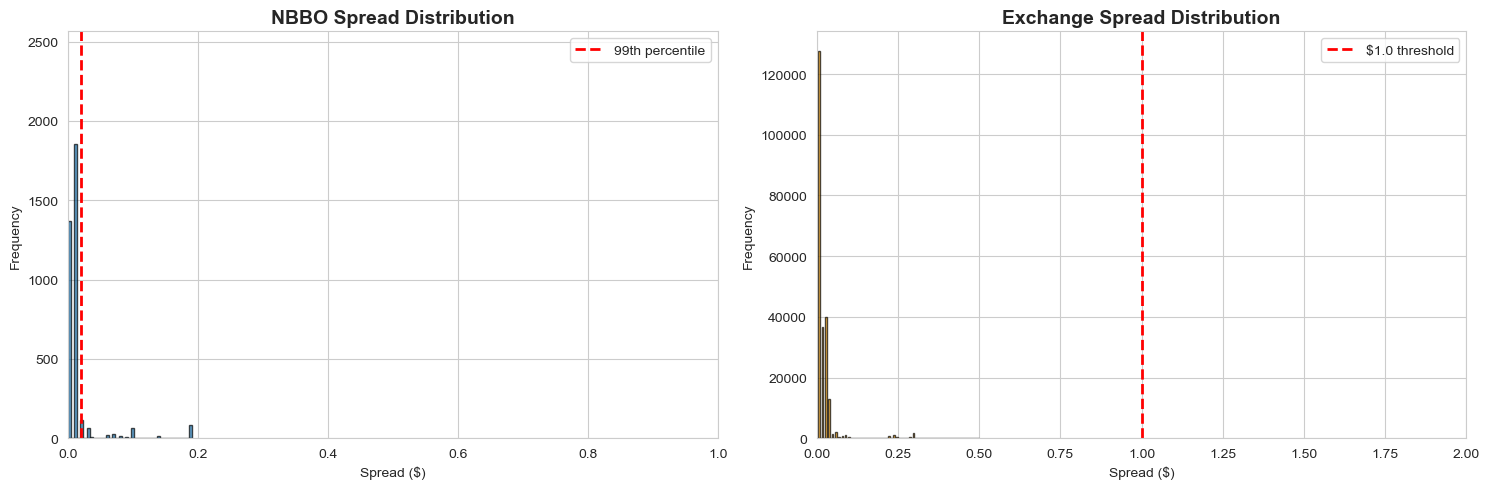

In [13]:
# Histogram of spreads
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# NBBO spreads
axes[0].hist(df['nbbo_spread'], bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(x=spread_threshold, color='red', linestyle='--', linewidth=2, label=f'99th percentile')
axes[0].set_title('NBBO Spread Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Spread ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].set_xlim(0, 1)

# Exchange spreads
axes[1].hist(ex_df['spread'], bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=wide_spread_threshold, color='red', linestyle='--', linewidth=2, label=f'${wide_spread_threshold} threshold')
axes[1].set_title('Exchange Spread Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Spread ($)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].set_xlim(0, 2)

plt.tight_layout()
plt.show()

## 6. Deep Dive: Specific Anomaly (14:34:30 - The Long Wick)

In [14]:
# Focus on the time period around 14:34:30 UTC (09:34:30 EST)
target_time = pd.Timestamp('2025-11-18 14:34:30')
window = pd.Timedelta(minutes=1)

anomaly_window = df[
    (df['timestamp'] >= target_time - window) & 
    (df['timestamp'] <= target_time + window)
].copy()

print(f"Analyzing window: {target_time - window} to {target_time + window}")
print(f"Samples in window: {len(anomaly_window)}")
print()
print("Statistics during anomaly window:")
print(f"  Mid price range: ${anomaly_window['nbbo_mid'].min():.2f} - ${anomaly_window['nbbo_mid'].max():.2f}")
print(f"  Max spread: ${anomaly_window['nbbo_spread'].max():.5f}")
print(f"  Max price jump: ${anomaly_window['mid_change'].max():.5f}")
print()
print("Samples with large jumps:")
large_jumps = anomaly_window[anomaly_window['mid_change'] > 2.0]
print(large_jumps[['timestamp', 'nbbo_bid', 'nbbo_ask', 'nbbo_mid', 'nbbo_spread', 'mid_change', 'best_bid_pub', 'best_ask_pub']])

Analyzing window: 2025-11-18 14:33:30 to 2025-11-18 14:35:30
Samples in window: 0

Statistics during anomaly window:
  Mid price range: $nan - $nan
  Max spread: $nan
  Max price jump: $nan

Samples with large jumps:
Empty DataFrame
Columns: [timestamp, nbbo_bid, nbbo_ask, nbbo_mid, nbbo_spread, mid_change, best_bid_pub, best_ask_pub]
Index: []


In [ ]:
# Examine exchange data during anomaly
def show_exchange_details(timestamp_str):
    """Show detailed exchange data for a specific timestamp."""
    target = pd.Timestamp(timestamp_str)
    row = df[df['timestamp'] == target].iloc[0]
    
    print(f"\nTimestamp: {row['timestamp']}")
    print(f"NBBO: Bid=${row['nbbo_bid']:.5f}, Ask=${row['nbbo_ask']:.5f}, Mid=${row['nbbo_mid']:.5f}, Spread=${row['nbbo_spread']:.5f}")
    print(f"Best Bid Pub: {PUBLISHER_NAMES.get(row['best_bid_pub'], row['best_bid_pub'])}")
    print(f"Best Ask Pub: {PUBLISHER_NAMES.get(row['best_ask_pub'], row['best_ask_pub'])}")
    print(f"\nExchanges ({row['num_exchanges']}):")
    for ex in row['exchanges']:
        print(f"  {ex['pub_name']:12} - Bid: ${ex['bid']:7.5f}, Ask: ${ex['ask']:7.5f}, Mid: ${ex['mid']:7.5f}, Spread: ${ex['spread']:6.5f}")

# Show some specific problematic timestamps
print("=" * 80)
print("EXAMINING SPECIFIC ANOMALIES")
print("=" * 80)

# Get timestamps with largest jumps
anomaly_timestamps = large_jumps.nlargest(3, 'mid_change')['timestamp'].values
for ts in anomaly_timestamps:
    show_exchange_details(ts)

In [ ]:
# Visualize the anomaly window
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Price during anomaly window
axes[0].plot(anomaly_window['timestamp'], anomaly_window['nbbo_bid'], label='NBBO Bid', linewidth=1, alpha=0.7)
axes[0].plot(anomaly_window['timestamp'], anomaly_window['nbbo_ask'], label='NBBO Ask', linewidth=1, alpha=0.7)
axes[0].plot(anomaly_window['timestamp'], anomaly_window['nbbo_mid'], label='NBBO Mid', linewidth=2, color='black')
axes[0].axvline(x=target_time, color='red', linestyle='--', linewidth=2, label='Target time')
axes[0].set_title(f'Price Around Anomaly ({target_time})', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Spread during anomaly window
axes[1].plot(anomaly_window['timestamp'], anomaly_window['nbbo_spread'], linewidth=1, color='orange')
axes[1].axvline(x=target_time, color='red', linestyle='--', linewidth=2, label='Target time')
axes[1].set_title('Spread During Anomaly Window', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Spread ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Publisher Quality Analysis

In [ ]:
# Analyze which publishers contribute to wide spreads
print("Publisher Analysis:")
print("=" * 80)

# Count how often each publisher has the best bid/ask
best_bid_counts = df['best_bid_pub'].value_counts()
best_ask_counts = df['best_ask_pub'].value_counts()

print("\nBest Bid Provider:")
for pub_id, count in best_bid_counts.items():
    pub_name = PUBLISHER_NAMES.get(pub_id, f'Unknown-{pub_id}')
    pct = 100 * count / len(df)
    print(f"  {pub_name:15} - {count:6,} ({pct:5.2f}%)")

print("\nBest Ask Provider:")
for pub_id, count in best_ask_counts.items():
    pub_name = PUBLISHER_NAMES.get(pub_id, f'Unknown-{pub_id}')
    pct = 100 * count / len(df)
    print(f"  {pub_name:15} - {count:6,} ({pct:5.2f}%)")

In [ ]:
# Find when each publisher contributes to wide NBBO spreads
wide_nbbo = df[df['nbbo_spread'] > 0.5].copy()  # Spreads wider than $0.50

print(f"\nSamples with NBBO spread > $0.50: {len(wide_nbbo)}")
print("\nBest Bid Provider for Wide Spreads:")
print(wide_nbbo['best_bid_pub'].value_counts().apply(lambda x: PUBLISHER_NAMES.get(x, f'Unknown-{x}') if isinstance(x, int) else x))
print("\nBest Ask Provider for Wide Spreads:")
print(wide_nbbo['best_ask_pub'].value_counts().apply(lambda x: PUBLISHER_NAMES.get(x, f'Unknown-{x}') if isinstance(x, int) else x))

## 8. Recommendations

Based on the analysis:

1. **Wide Spread Filtering**: Consider filtering out quotes with spreads > $0.50 or > 3x median spread
2. **Publisher-Specific Filtering**: NYSE (Publisher 2) appears to have many stale/wide quotes
3. **Time-Based Filtering**: Some anomalies occur at specific times (possibly exchange open/close)
4. **Mid Price Calculation**: Consider using volume-weighted mid or rejecting wide markets

### Proposed Filter
```python
# Filter out samples where:
# 1. Spread > $1.00 (clearly stale)
# 2. Spread > 10x median spread
median_spread = df['nbbo_spread'].median()
df_filtered = df[
    (df['nbbo_spread'] <= 1.0) & 
    (df['nbbo_spread'] <= 10 * median_spread)
]
```

In [ ]:
# Test the filtering approach
median_spread = df['nbbo_spread'].median()
df_filtered = df[
    (df['nbbo_spread'] <= 1.0) & 
    (df['nbbo_spread'] <= 10 * median_spread)
].copy()

print(f"Original samples: {len(df):,}")
print(f"Filtered samples: {len(df_filtered):,}")
print(f"Removed: {len(df) - len(df_filtered):,} ({100*(len(df) - len(df_filtered))/len(df):.2f}%)")
print()
print("Filtered statistics:")
print(f"  Mean spread: ${df_filtered['nbbo_spread'].mean():.5f} (was ${df['nbbo_spread'].mean():.5f})")
print(f"  Max spread: ${df_filtered['nbbo_spread'].max():.5f} (was ${df['nbbo_spread'].max():.5f})")
print(f"  Price range: ${df_filtered['nbbo_mid'].min():.2f} - ${df_filtered['nbbo_mid'].max():.2f}")
print(f"    (was ${df['nbbo_mid'].min():.2f} - ${df['nbbo_mid'].max():.2f})")

In [ ]:
# Compare before/after filtering
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Original data
axes[0].plot(df['timestamp'], df['nbbo_mid'], linewidth=0.5, alpha=0.7)
axes[0].set_title('NBBO Mid Price - Original Data', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# Filtered data
axes[1].plot(df_filtered['timestamp'], df_filtered['nbbo_mid'], linewidth=0.5, alpha=0.7, color='green')
axes[1].set_title('NBBO Mid Price - Filtered Data (No Wide Spreads)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Price ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()